# Plant growth

The study presented in that section focuses on the growth of particular plant (not specified).
The objective is to predict which height will be reached by the plant ...
for example in order to evaluate the risk that the plant might require un greater jag on the balcony ...

The problem is that we have no data on the height usually reached by this kind of plant, which prohibits any use of statistics tools ...
So ... what ? Yet we have the following information:

   - we know the influence of the quality of the light and the influence of the air moisture rate on the plant growth,
   - we can quantify the quality of the light we have at home and also the air moisture rate where the plant lives.

.... so we can model the plant growth thanks to a Bayes net and then have access to the variability of its final height!

Let us imagine (for the example purpose): 

 - Some meteorological data (tropical place?): 

   - the balcony is in plain light 3 times out of 4,
   - in the darkness, the air is moist 8 times out of 10,
   - in plain light, the air is dry 6 times out of 10.

 - Some remembrance of biology trainings:

   - in plain light, if the air is moist, the plant is very happy: it grows 90cm on average with a variation of $\pm$ 10 cm. If the air is too dry, it will not grow more than 30 cm but we reasonnably can expect about a 15 cm growth.
   - in the darkness, if the air is too dry, the plant suffers: it will not grow more than 20 cm and might die as well! If the air is moist, it will  usually grow about 30 cm, at least 15cm but not more than 50 cm.



In [1]:
from __future__ import print_function
import openturns as ot
import otagrum
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

We have to build the Bayes Net now. There are 3 variables that will be named : $Light$, $Moisture$ and $Height$.

In [2]:
# Create variables
light = gum.LabelizedVariable("Light", "quality of light", 0)
moisture = gum.LabelizedVariable("Moisture", "quantity of moisture", 0)
height = gum.DiscretizedVariable("Height", "plant growth")

Both variables $Light$ and $Moisture$ are categorical variables whith the following attributes:  

 - $Light$ has 2 attributes: $Dim$ which refers to the darkness and $Bright$ which refers to plain light situations,
 - $Moisture$ has 2 attributes: $Dry$ which refers to dry air situations and $Wet$ which refers to wet air situations.

$Height$ is a continuous variable which has to be discretized for the Bayes Net use.

In [3]:
## Create labels and ticks

# light has 2 attributes : Dim and Bright
light.addLabel("Dim")
light.addLabel("Bright")

# moisture has 2 attributes : Dry and Wet
moisture.addLabel("Dry")
moisture.addLabel("Wet")

# height is a discretized variable
[height.addTick(i) for i in range(0, 150, 10)]
height.domainSize()

14

Furthermore, there are several influence links : $Light$ on $Moisture$, $(Light,Moisture)$ on $Height$.

In [4]:
## Create the net
bn = gum.BayesNet("Plant Growth")

# Add variables
indexLight    = bn.add(light)
indexMoisture = bn.add(moisture)
indexHeight   = bn.add(height)

# Add arcs
bn.addArc(indexLight, indexMoisture)
bn.addArc(indexLight, indexHeight)
bn.addArc(indexMoisture, indexHeight)
bn

(gum::BayesNet<double>@0x2e8ca10) BN{nodes: 3, arcs: 3, domainSize: 56, parameters: 62, compression ratio: -10% }

The next step is the quantification of the Bayes net.

The variable $Light$ is quantified as follows:
    
 - $Light=Dim$ with a probability of 0.25,
 - $Light=Bright$ with a probability of 0.75.

In [5]:
# Create conditional probability tables
# light conditional probability table
bn.cpt(indexLight)[:]= [0.25, 0.75]
gnb.showPotential(bn.cpt(indexLight))

The influence of $Light$ on $Moisture$ is modelized by:
 - when $Light=Dim$ then  $Moisture=Dry$ with a probability of 0.2 and  $Moisture=Wet$ with a probability of 0.8,
 - when $Light=Bright$ then  $Moisture=Dry$ with a probability of 0.6 and  $Moisture=Wet$ with a probability of 0.4.

In [6]:
# moisture conditional probability table
# We show the antecedents of moisture with the order in which they were declared
bn.cpt(indexMoisture)[{'Light' : 'Dim'}] = [0.2, 0.8]
bn.cpt(indexMoisture)[{'Light' : 'Bright'}] = [0.6, 0.4]
gnb.showPotential(bn.cpt(indexMoisture))

The influence of $(Light, Moisture)$ on $Height$ is modelized by:
 - when $Light=Dim$ and $Moisture=Dry$ then $Height$ follows a $Uniform(min=0, max=20)$ distribution,
 - when $Light=Dim$ and $Moisture=Wet$ then $Height$ follows a $Triangular(min=15, mod=30, max=50)$ distribution,
 - when $Light=Bright$ and $Moisture=Dry$ then $Height$ follows a $Triangular(min=0, mod=15, max=30)$ distribution,
 - when $Light=Bright$ and $Moisture=Wet$ then $Height$ follows a $Normal(\mu=90, \sigma=10)$ distribution.

In [7]:
# height has a conditional probability table
# We give here its conditional distributions

# distribution when Dim and Dry
heightWhenDimAndDry = ot.Uniform(0.0, 20.0)
# distribution when Dim and Wet
heightWhenDimAndWet = ot.Triangular(15.0, 30.0, 50.0)
# distribution when Bright and Dry
heightWhenBrightAndDry = ot.Triangular(0.0, 15.0, 30.0)
# distribution when Bright and Wet
heightWhenBrightAndWet = ot.Normal(90.0, 10.0)

# We have to enter some OT distributions whithin aGrUM conditional probability tables
# We show the antecedents of height with the order in which they were declared
# The new class Utils from otagrum is able to marry OT distributions and Agrum conditional probability tables
bn.cpt(indexHeight)[{'Light': 'Dim', 'Moisture': 'Dry'}]   = otagrum.Utils.Discretize(heightWhenDimAndDry, height)[:]
bn.cpt(indexHeight)[{'Light': 'Bright', 'Moisture': 'Dry'}] = otagrum.Utils.Discretize(heightWhenBrightAndDry, height)[:]
bn.cpt(indexHeight)[{'Light': 'Dim', 'Moisture': 'Wet'}]    = otagrum.Utils.Discretize(heightWhenDimAndWet, height)[:]
bn.cpt(indexHeight)[{'Light': 'Bright', 'Moisture': 'Wet'}] = otagrum.Utils.Discretize(heightWhenBrightAndWet, height)[:]
gnb.showPotential(bn.cpt(indexHeight))

We can study the plant growth variability in different situations like:

 - I put my plant on my balcony; in that situation, I set none evidence inside the Bayes net.
 - I put my plant in a  place where it is dark all time (in my cellar?); in that situation, I set one evidence inside the Bayes net: $Light=Dim$.
 - I put my plant in a  place where it is moist all time (in my bathroom?); in that situation, I set one evidence inside the Bayes net: $Moisture=Wet$.

Probability (height > 40cm) =  0.32857134257593246


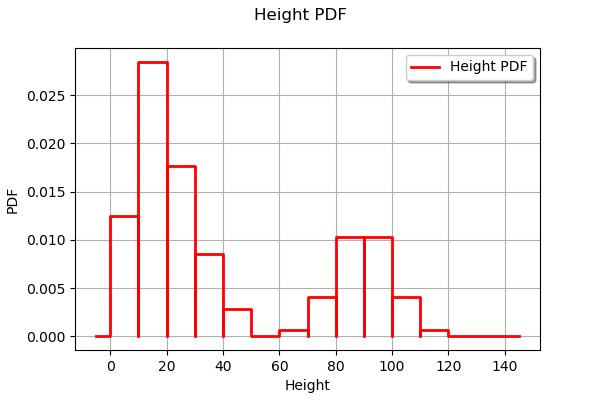

In [8]:
# Variability of the plant growth on my balcony

ie = gum.LazyPropagation(bn)
h_dist = otagrum.Utils.FromMarginal(ie.posterior("Height"))
print("Probability (height > 40cm) = ", 1.0 - h_dist.computeCDF(40.0))
h_dist.drawPDF()

Probability (height > 40cm)|Light=Dim =  0.11428571428571421


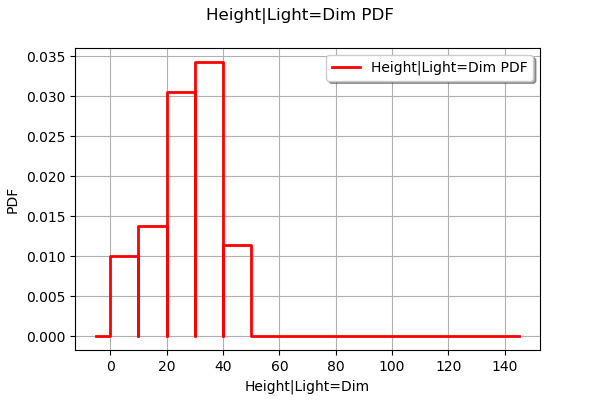

In [9]:
# Variability of the plant growth in my cellar

ie = gum.LazyPropagation(bn)
ie.setEvidence({'Light':'Dim'})

h_dist_dim = otagrum.Utils.FromMarginal(ie.posterior("Height"))
h_dist_dim.setDescription(['Height|Light=Dim'])
print("Probability (height > 40cm)|Light=Dim = ", 1.0 - h_dist_dim.computeCDF(40.0))
h_dist_dim.drawPDF()

Probability (height > 40cm)|Moisture=Wet =  0.6571426851518646


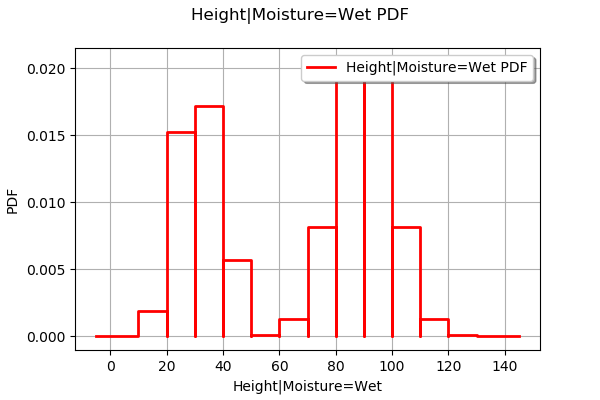

In [10]:
# Variability of the plant growth when the atmosphere is very wet

ie = gum.LazyPropagation(bn)
ie.setEvidence({'Moisture':'Wet'})

h_dist_wet = otagrum.Utils.FromMarginal(ie.posterior("Height"))
h_dist_wet.setDescription(['Height|Moisture=Wet'])
print("Probability (height > 40cm)|Moisture=Wet = ", 1.0 - h_dist_wet.computeCDF(40.0))
h_dist_wet.drawPDF()

UserDefined({x = [0], p = 0.4}, {x = [1], p = 0.6})


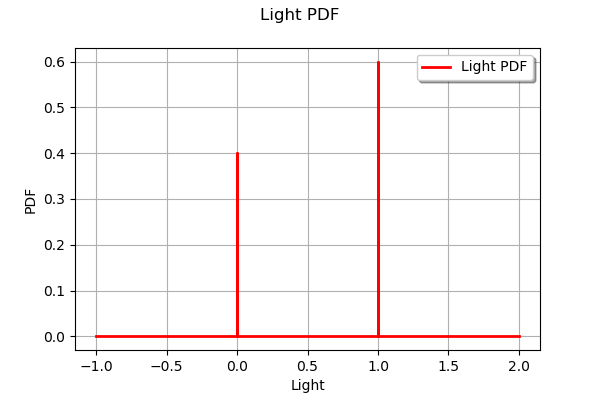

In [11]:
# Get the distribution of the variable "Light"

l_dist_wet = otagrum.Utils.FromPotential(ie.posterior("Light"))
print(l_dist_wet)
l_dist_wet.drawPDF()

In [12]:
# Get the joint distribution [H, M]
ie = gum.LazyPropagation(bn)
ie.addJointTarget(["Height", "Moisture"])
ie.makeInference()
h_m_dist = otagrum.Utils.FromPotential(ie.jointPosterior(["Height", "Moisture"]))
print(h_m_dist.getDescription())
print(h_m_dist.getMarginal(0))

[Moisture,Height]
UserDefined({x = [0], p = 0.5}, {x = [1], p = 0.5})
